In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import seaborn as sns

In [3]:
try:
    filename = str(snakemake.input.results)
    fail_count_filename = str(snakemake.input.fail_counts)
    figdir = "latex/figures/"
except NameError:
    filename = "../../results/toy-data/results.csv"
    fail_count_filename = "../../results/toy-data/fail-counts.csv"
    figdir = "../../latex/figures/"
df = pd.read_csv(filename)
fail_count_df = pd.read_csv(fail_count_filename)

df["center"] = 0.5 * (df["end"] + df["start"])
df["radius"] = df["length"] / 2

In [4]:
fail_count_df.fail_count.value_counts()

0    1182
1      14
2       3
3       1
Name: fail_count, dtype: int64

In [5]:
plt.style.use("default")

In [6]:
df["algo-type"] = df["data_generation_algorithm"] + " " + df["type"]
true_params = np.array((1, 0))

In [7]:
df = df.query(
    '(data_generation_algorithm not in ["max-ent-automatic-queries-4", "max-ent-automatic-queries-6"])'\
    '& (type != "regular")'
)

In [8]:
conf_levels = [0.8, 0.9, 0.95]
eps_to_plot = [0.1, 0.25, 0.5, 1.0, 10, 100]
d = 2

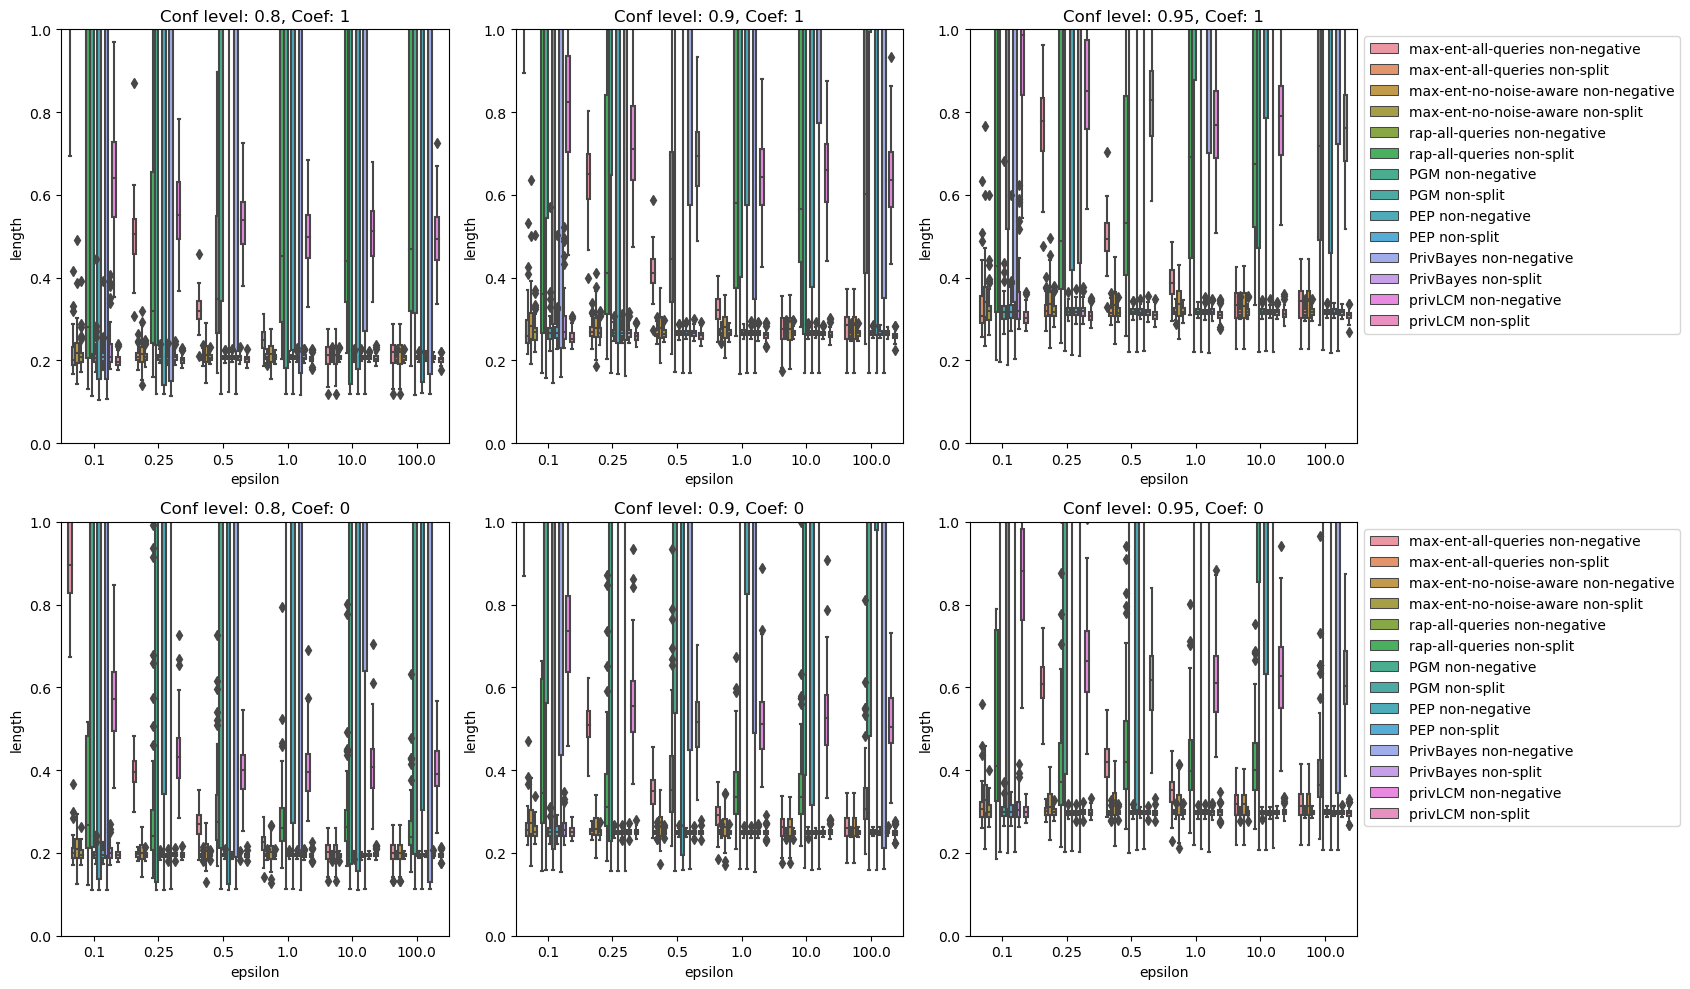

In [10]:
fig, axes = plt.subplots(d, len(conf_levels), figsize=(17, 10))
cl_count = len(conf_levels)
for i in range(d):
    for j, conf_level in enumerate(conf_levels):
        ax = axes[i, j]
        sdf = df.loc[df["conf_level"] == conf_level].loc[df["dimension"] == i].loc[df["epsilon"].apply(lambda x: x in eps_to_plot)]
        sns.boxplot(x="epsilon", y="length", hue="algo-type", data=sdf, ax=ax, dodge=True)
        ax.set_title("Conf level: {}, Coef: {}".format(conf_level, true_params[i]))
        ax.set_ylim(0, 1)
        if j < cl_count - 1:
            ax.get_legend().remove()
    axes[i, cl_count - 1].legend(loc="upper left", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.savefig(figdir + "lengths.pdf")
plt.show()

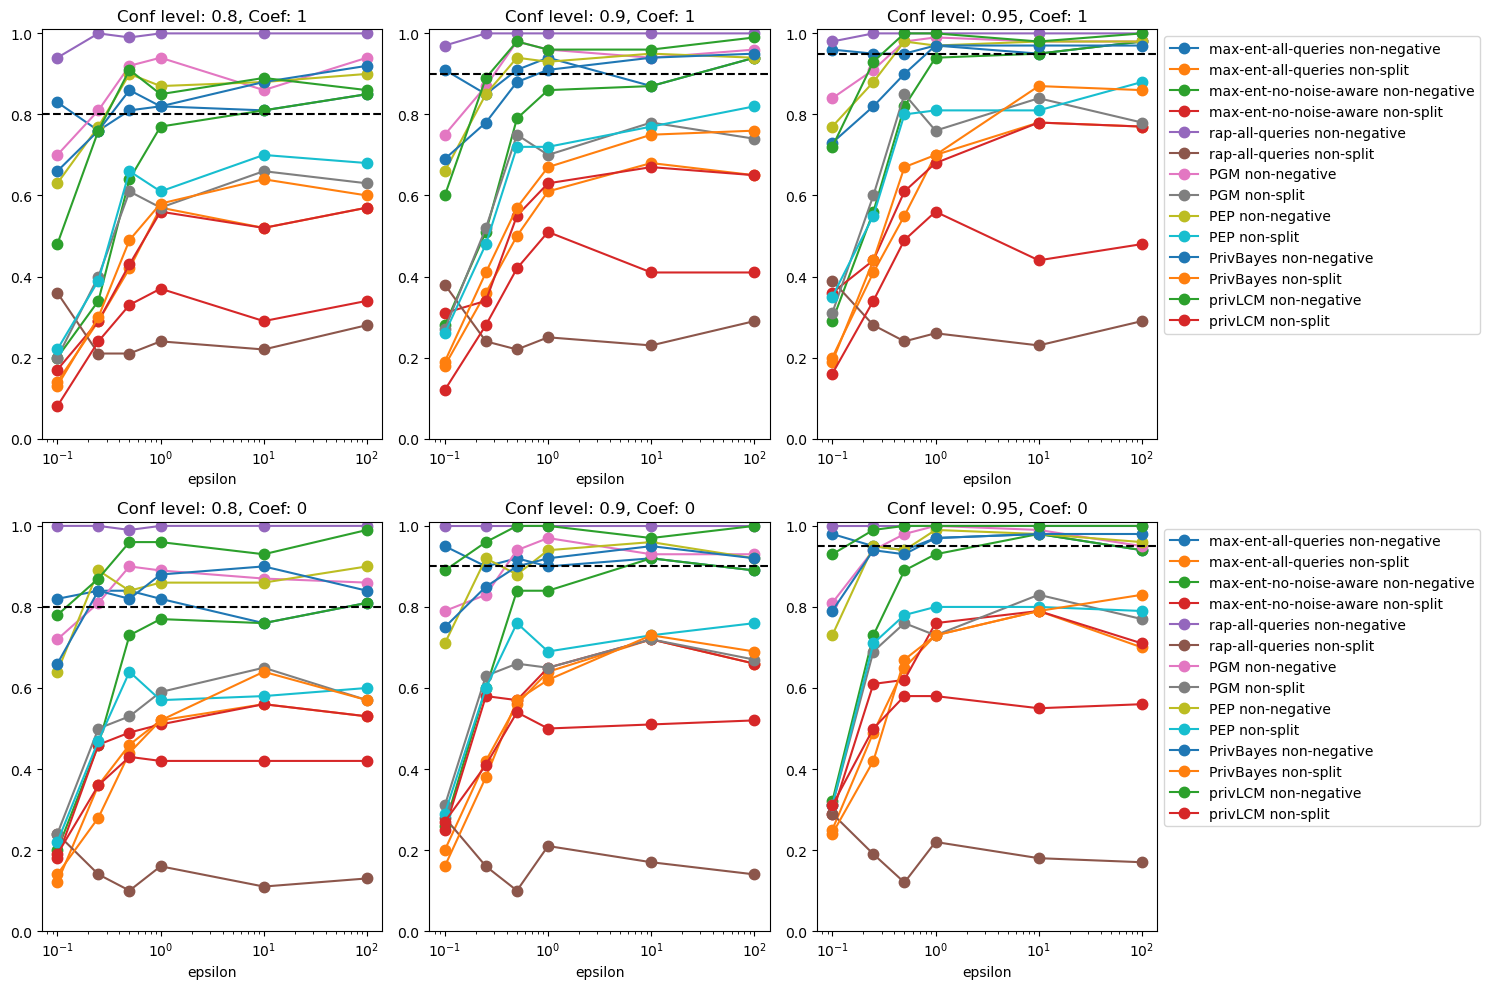

In [11]:
coverages = df.groupby(["conf_level", "epsilon", "dimension", "algo-type"])["has_coverage"].mean()

fig, axes = plt.subplots(d, len(conf_levels), figsize=(15, 10))
for i in range(d):
    for j, conf_level in enumerate(conf_levels):
        ax = axes[i, j]
        sdf = coverages.loc[conf_level, :, i, :]
        for ci_type in df["algo-type"].unique():
            sdf.loc[:, ci_type].plot(ax=ax, label=ci_type, marker=".", markersize=15)
        ax.legend()
        ax.set_ylim(0, 1.01)
        ax.set_xticks(eps_to_plot)
        ax.set_xscale("log")
        ax.axhline(conf_level, linestyle="dashed", color="black")
        ax.set_title("Conf level: {}, Coef: {}".format(conf_level, true_params[i]))
        if j < cl_count - 1:
            ax.get_legend().remove()
    axes[i, cl_count - 1].legend(loc="upper left", bbox_to_anchor=(1.0, 1))
        
plt.tight_layout()
plt.savefig(figdir + "coverage.pdf")
plt.show()

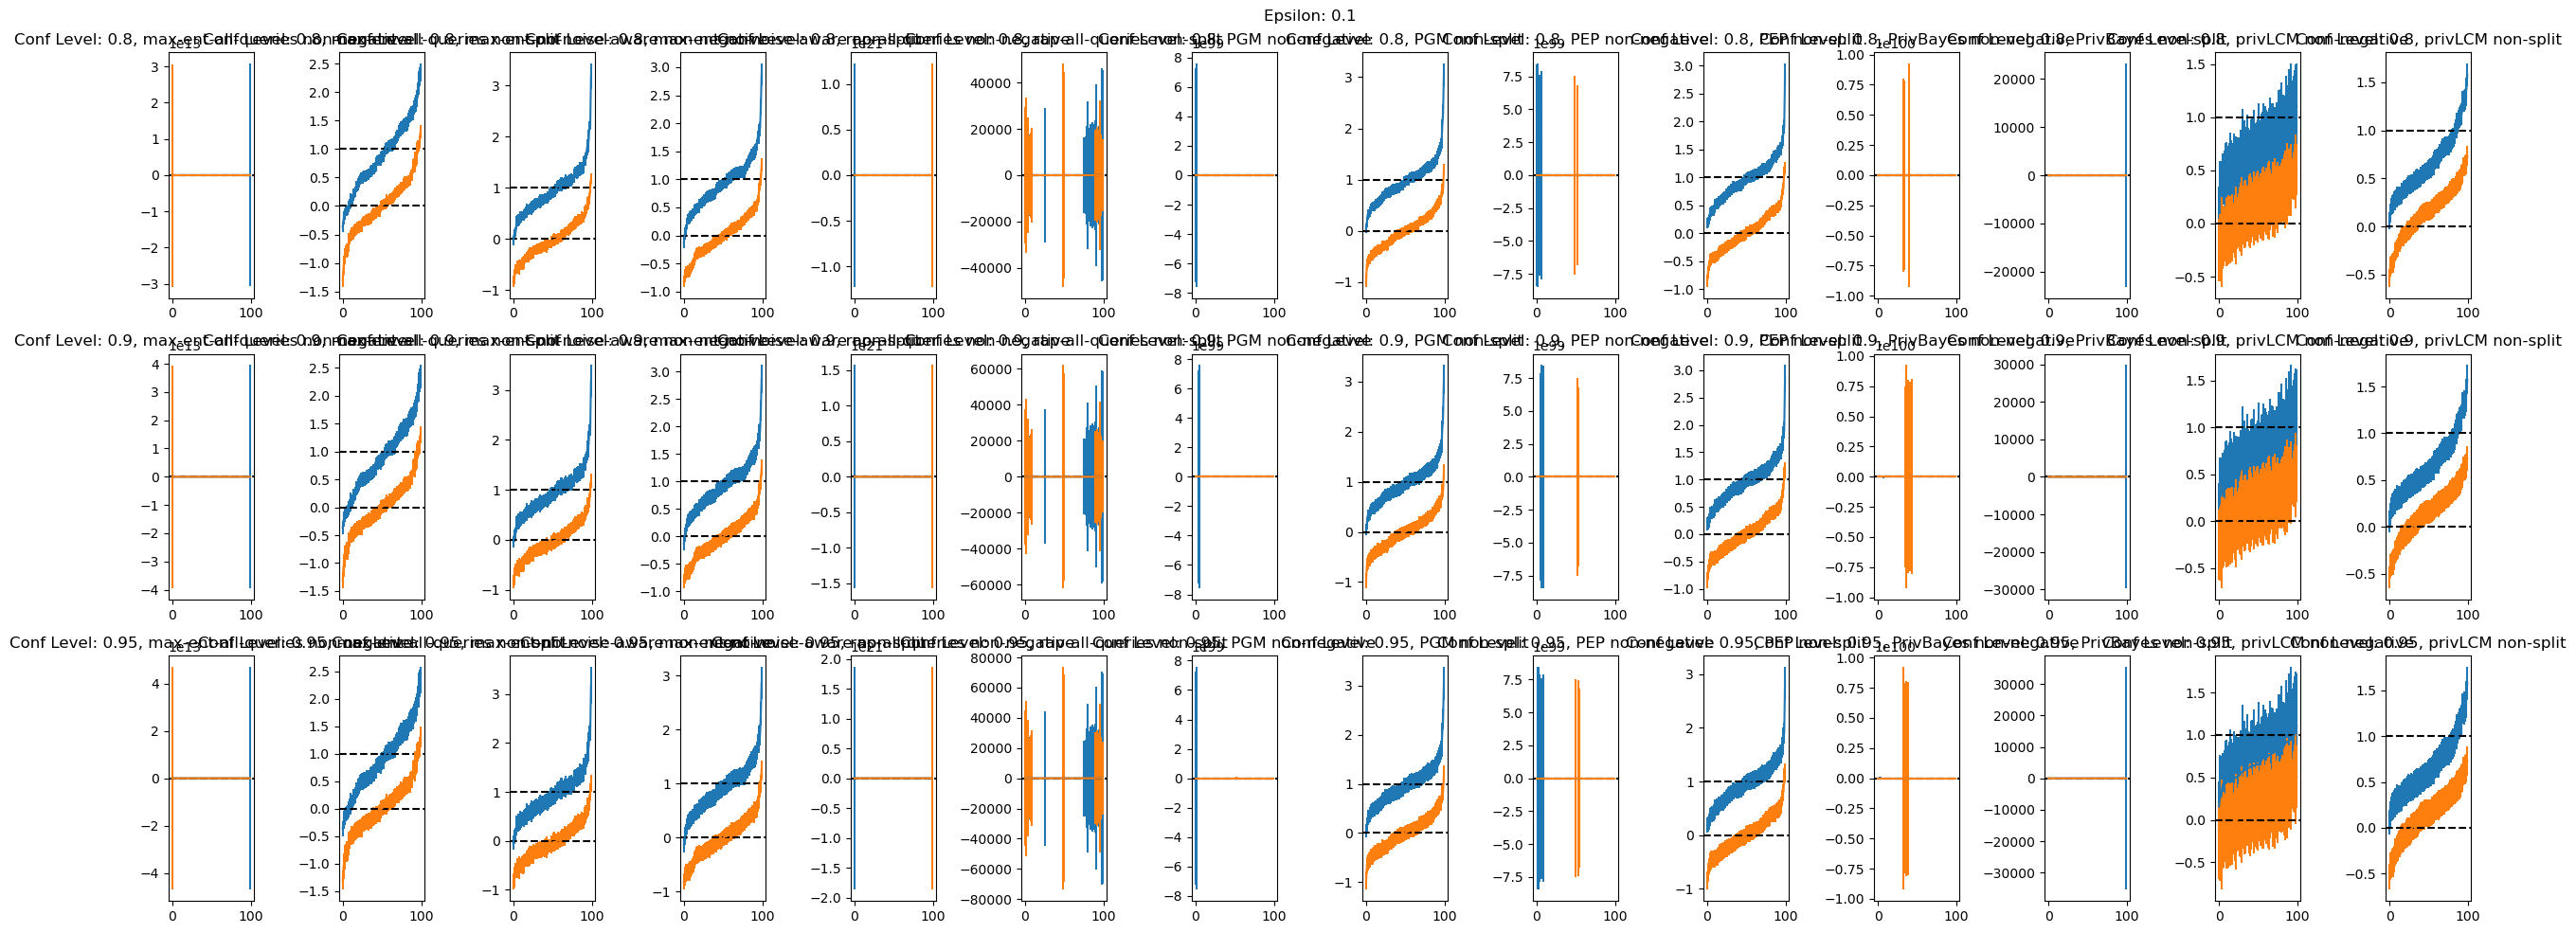

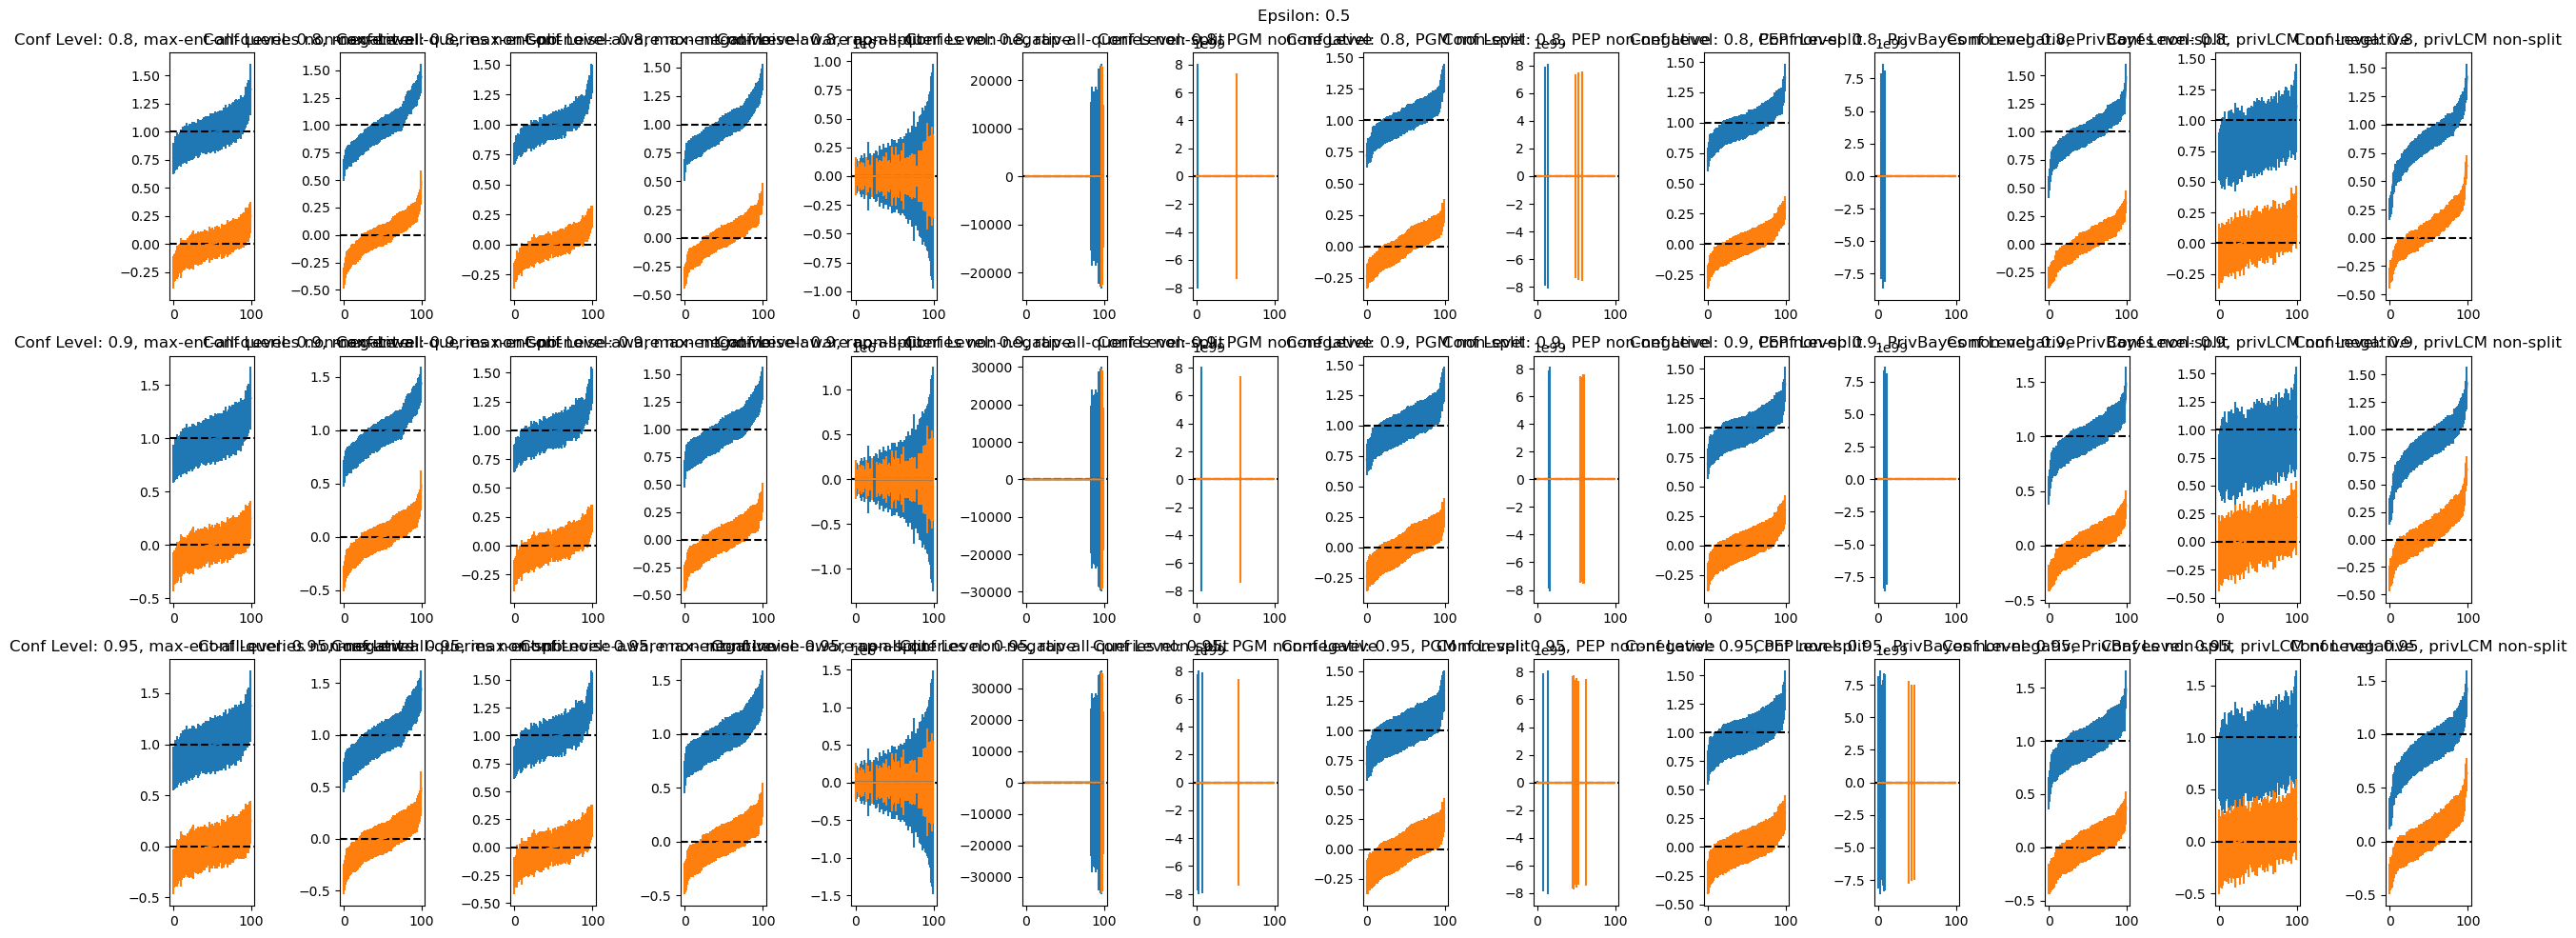

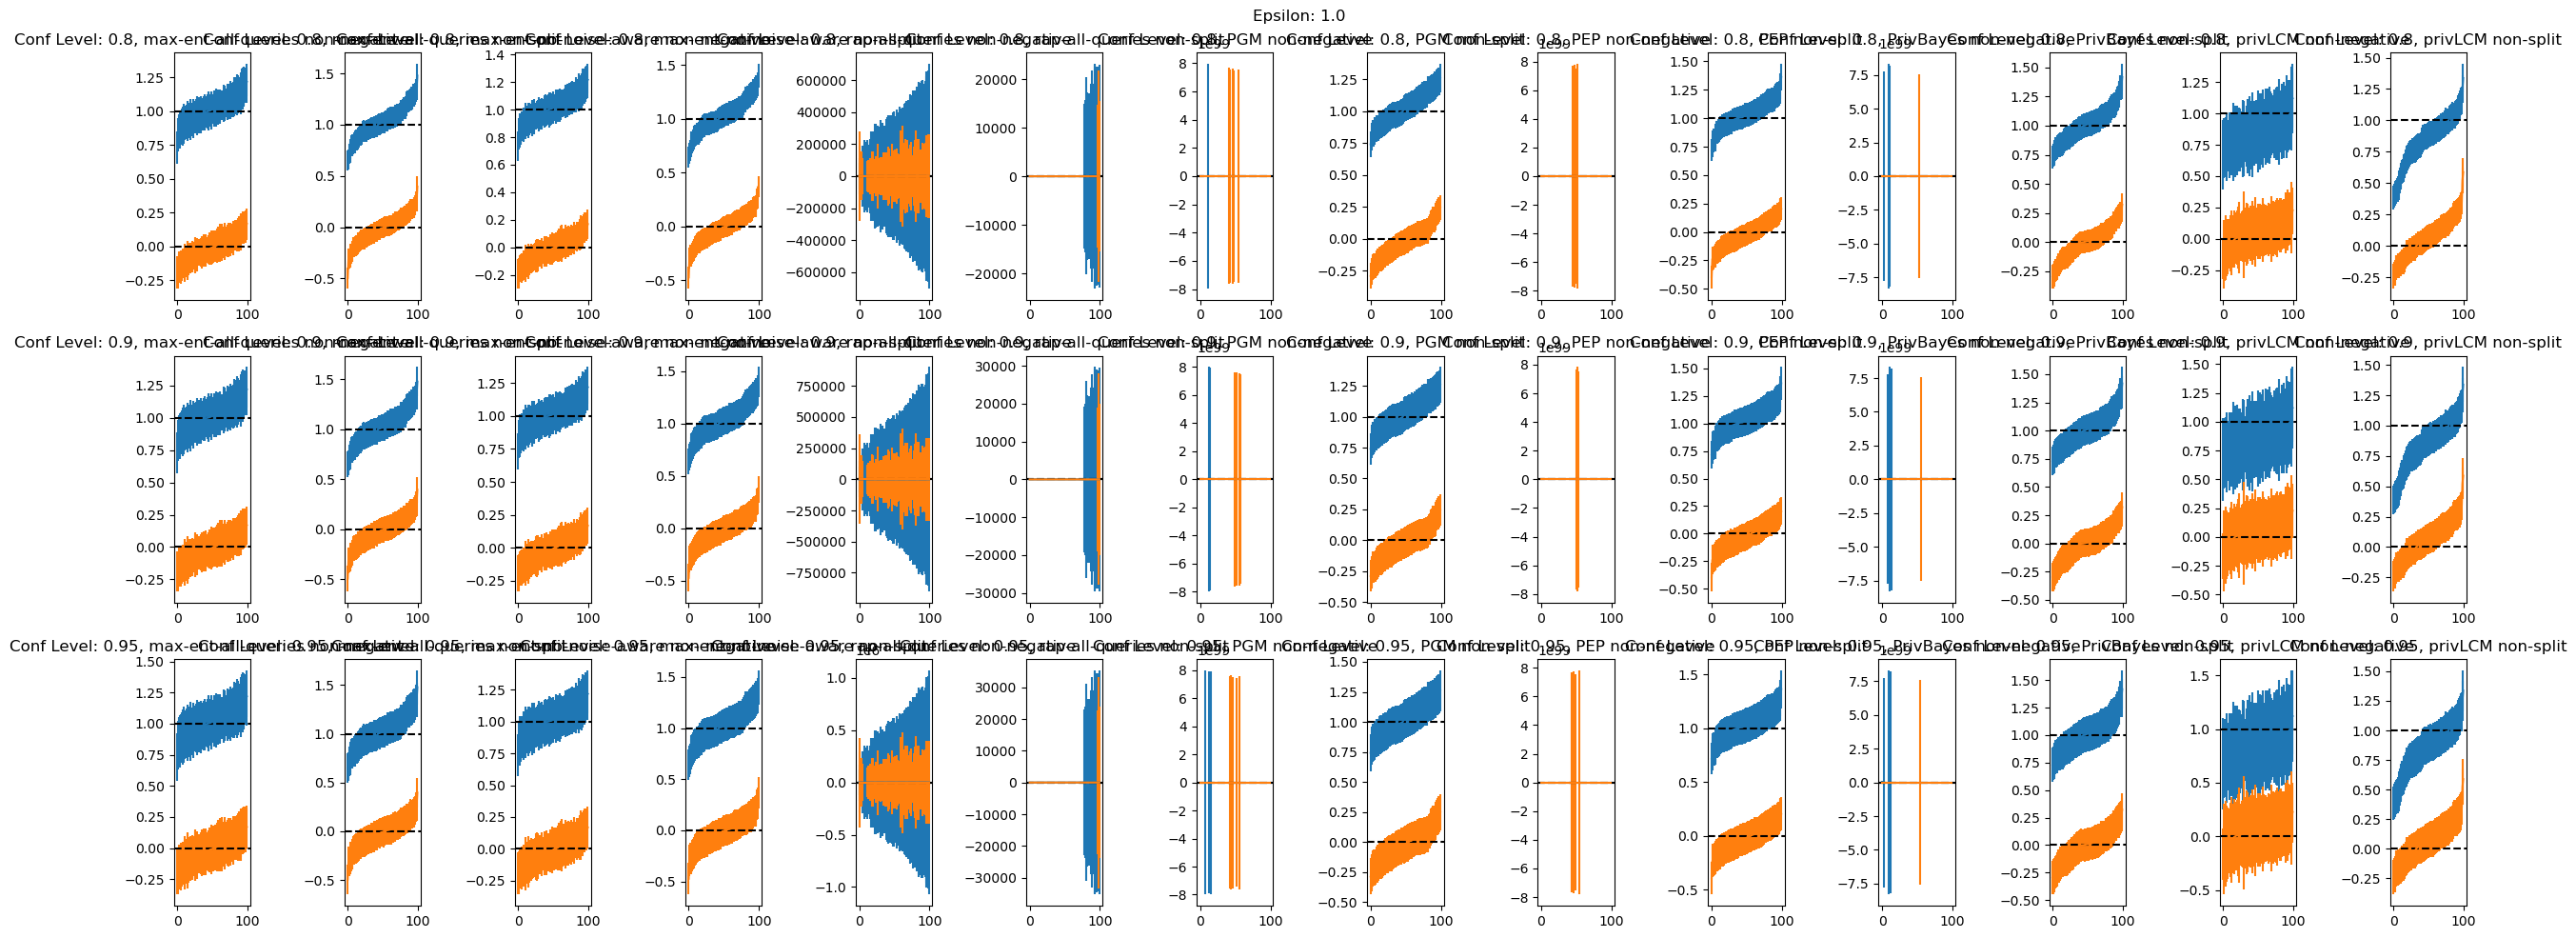

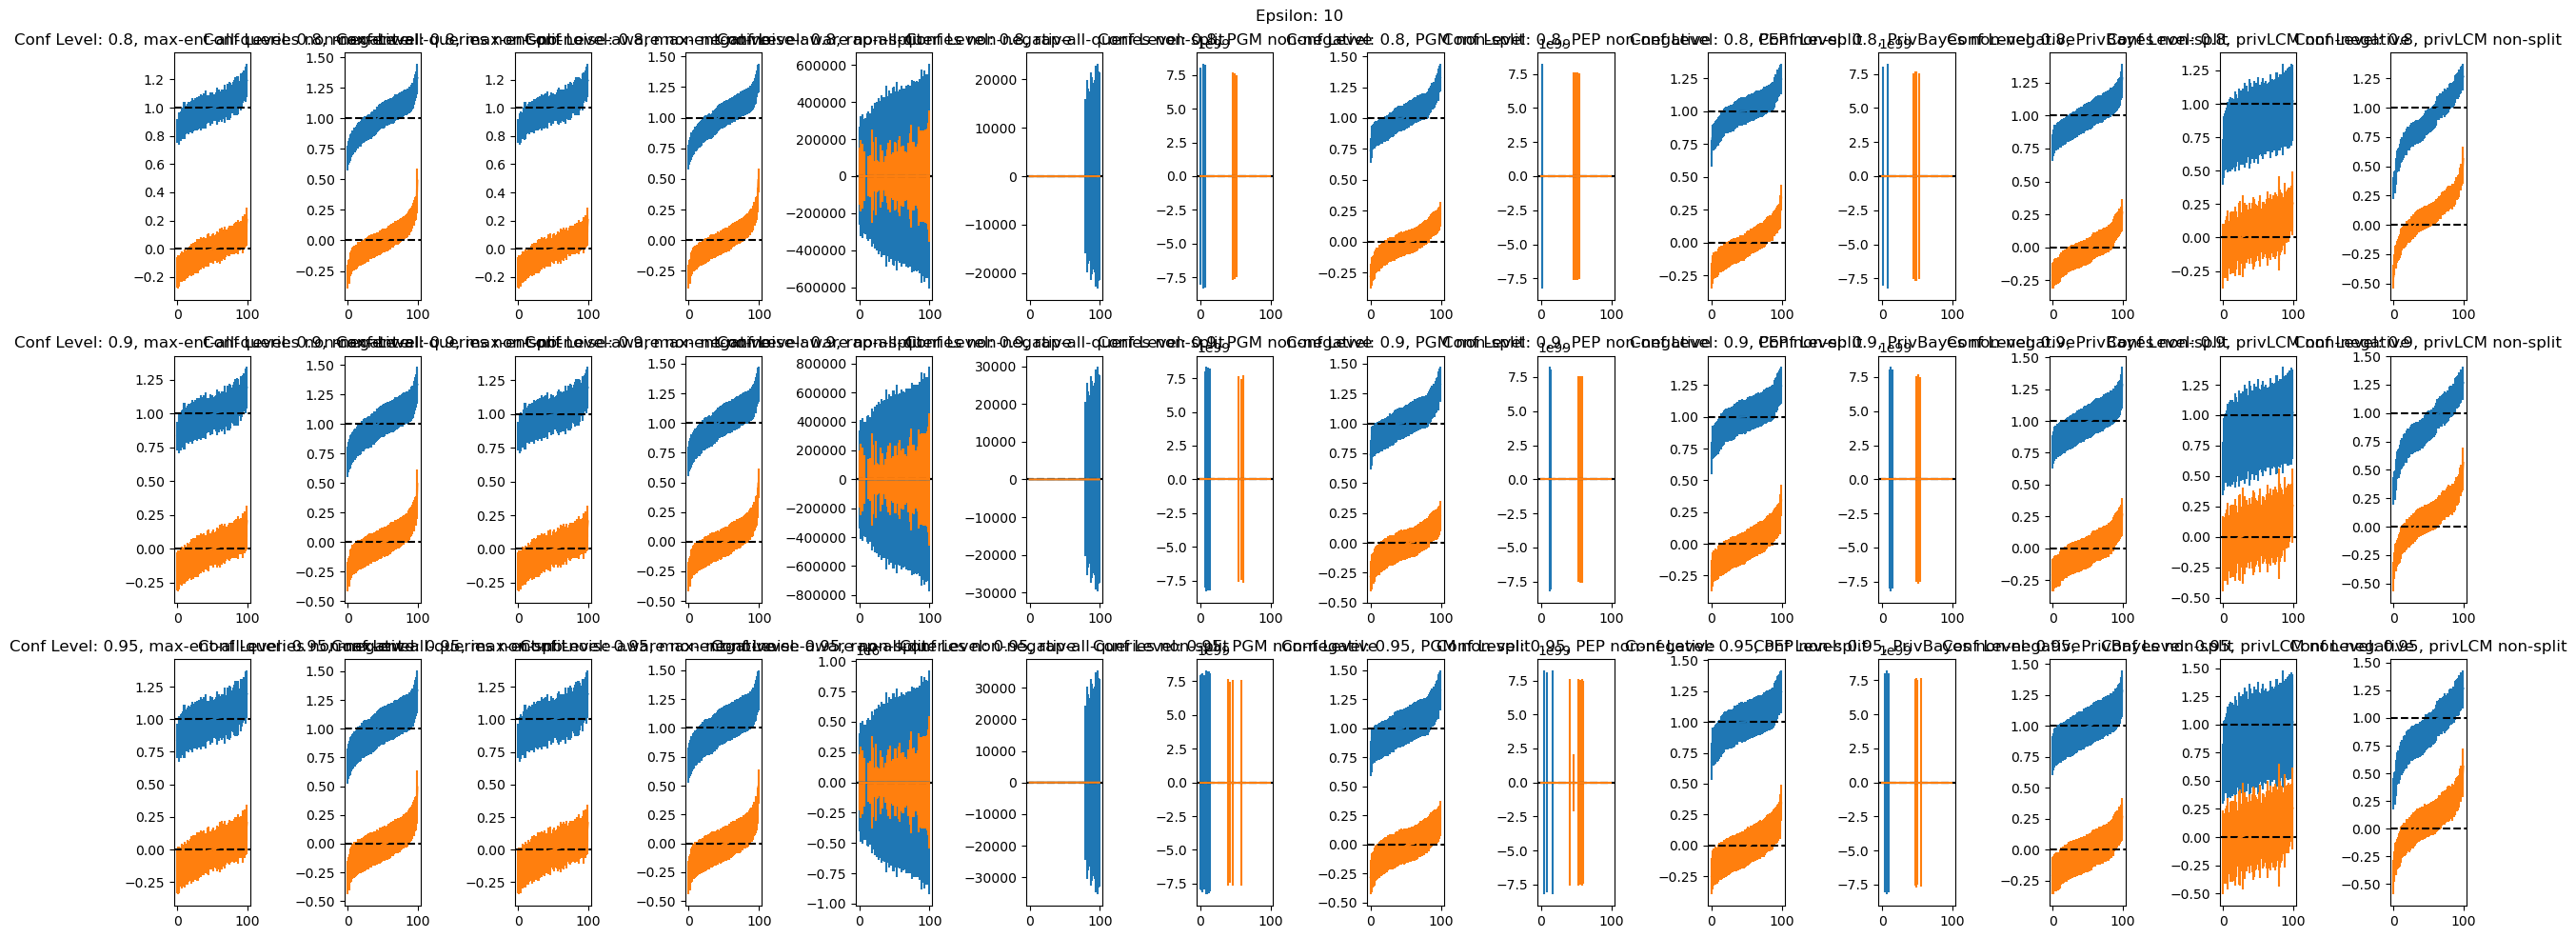

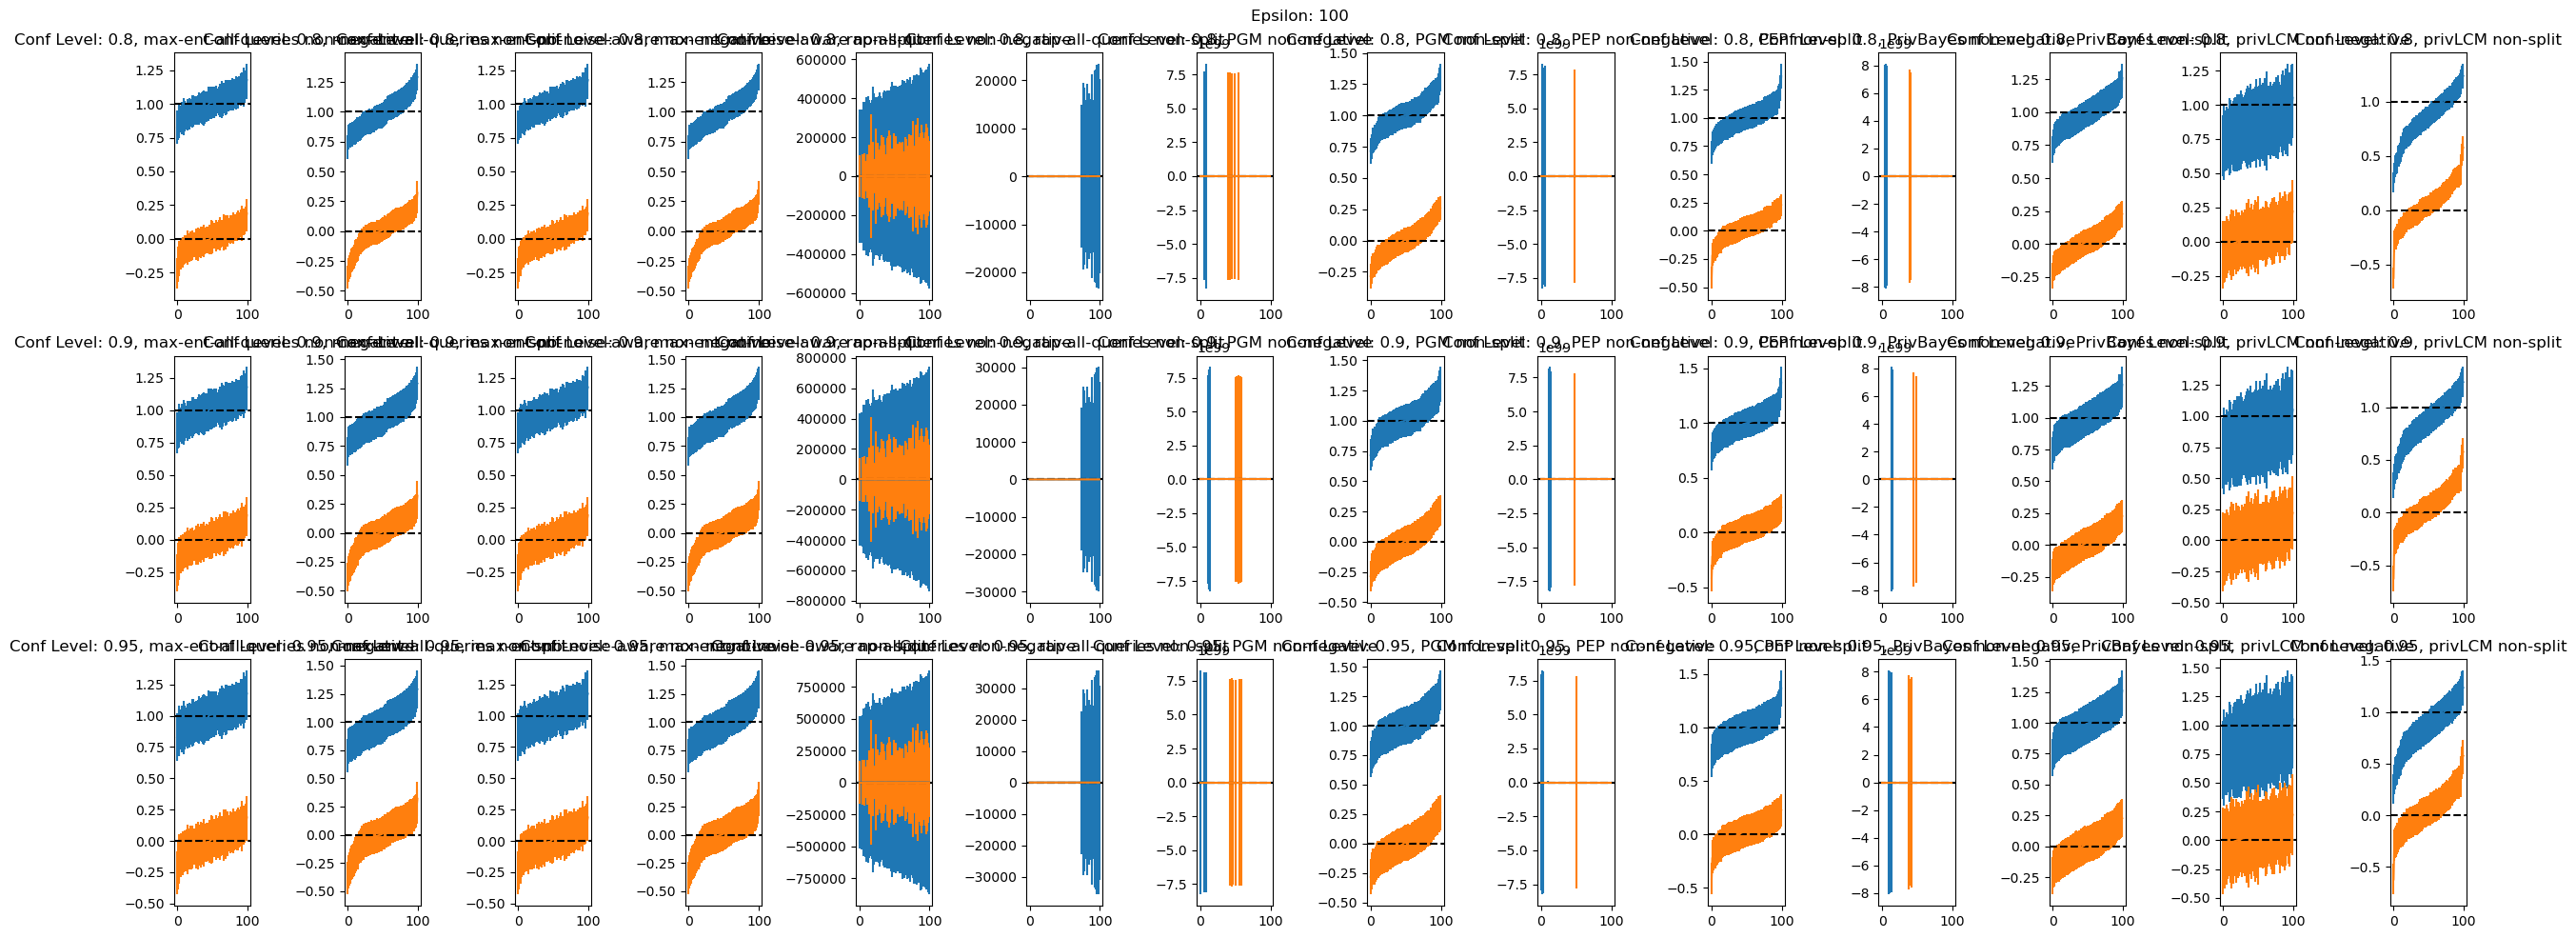

In [12]:
ci_types = df["algo-type"].unique()

for epsilon in [0.1, 0.5, 1.0, 10, 100]:
    fig, axes = plt.subplots(len(conf_levels), len(ci_types), figsize=(25, 10))
    fig.suptitle("Epsilon: {}".format(epsilon))
    for j, conf_level in enumerate(conf_levels):
        for i in range(d):
            sdf = df.loc[df["conf_level"] == conf_level].loc[df["dimension"] == i].loc[df["epsilon"] == epsilon]

            for ci_type_index, ci_type in enumerate(ci_types):
                ax = axes[j, ci_type_index]
                sdf_type = sdf.loc[sdf["algo-type"] == ci_type]
                inds = sdf_type["center"].sort_values().index
                ax.errorbar(
                    range(sdf_type.shape[0]), 
                    y=sdf_type.loc[inds]["center"],
                    yerr=sdf_type.loc[inds]["radius"],
                )
                ax.axhline(true_params[i], linestyle="dashed", color="black")
                ax.set_title("Conf Level: {}, {}".format(conf_level, ci_type))
           
    plt.tight_layout()
    plt.savefig(figdir + "conf_ints_eps_{}.pdf".format(epsilon))
    plt.show()

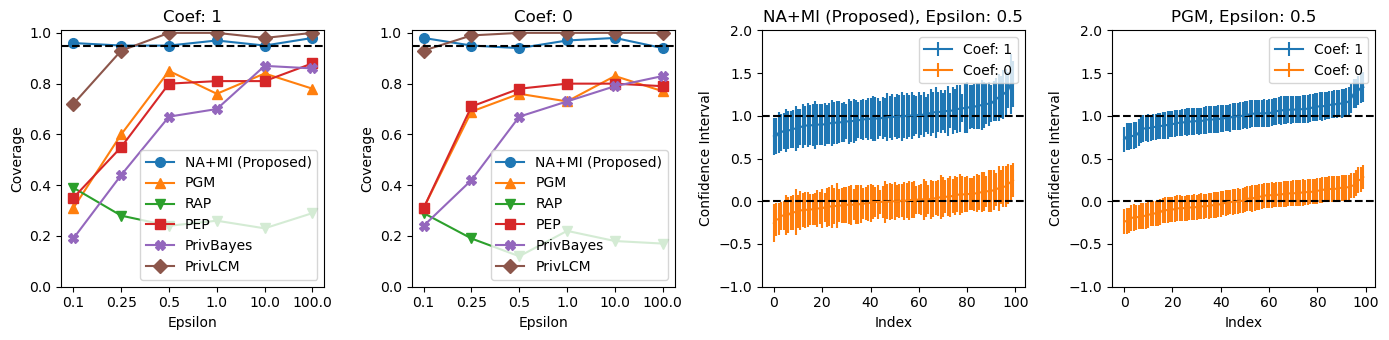

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))

conf_level = 0.95
ci_types = [
    "max-ent-all-queries non-negative", 
    "PGM non-split", "rap-all-queries non-split", 
    "PEP non-split", 
    "PrivBayes non-split",
    "privLCM non-negative",
    # "privLCM non-split",
]
algorithm_labels = {
    "max-ent-all-queries non-negative": "NA+MI (Proposed)", "PGM non-split": "PGM", 
    "rap-all-queries non-split": "RAP", "PEP non-split": "PEP",
    "PrivBayes non-split": "PrivBayes",
    "privLCM non-negative": "PrivLCM",
    # "privLCM non-split": "PrivLCM",
}
markers = {
    "max-ent-all-queries non-negative": "o", 
    "PGM non-split": "^", 
    "rap-all-queries non-split": "v", 
    "PEP non-split": "s", 
    "privLCM non-negative": "D",
    "PrivBayes non-split": "X"
}
for i in range(d):
    sdf = coverages.loc[conf_level, :, i, :]
    for ci_type in ci_types:
        cover_by_eps = sdf.loc[:, ci_type]
        axes[i].plot(cover_by_eps.index.astype(str), cover_by_eps, label=algorithm_labels[ci_type], marker=markers[ci_type], markersize=7)
    
    axes[i].legend()
    axes[i].set_ylim(0, 1.01)
    axes[i].axhline(conf_level, linestyle="dashed", color="black")
    axes[i].set_title("Coef: {}".format(true_params[i]))
    axes[i].set_xlabel("Epsilon")
    axes[i].set_ylabel("Coverage")

epsilon = 0.5
highlighted_ci_types = ["max-ent-all-queries non-negative", "PGM non-split"]
for i in range(d):
    sdf = df.loc[df["conf_level"] == conf_level].loc[df["dimension"] == i].loc[df["epsilon"] == epsilon]

    for ci_type_index, ci_type in enumerate(highlighted_ci_types):
        ax = axes[2 + ci_type_index]
        sdf_type = sdf.loc[sdf["algo-type"] == ci_type]
        inds = sdf_type["center"].sort_values().index
        ax.errorbar(
            range(sdf_type.shape[0]), 
            y=sdf_type.loc[inds]["center"],
            yerr=sdf_type.loc[inds]["radius"],
            label="Coef: {}".format(true_params[i])
        )
        ax.axhline(true_params[i], linestyle="dashed", color="black")
        ax.set_title("{}, Epsilon: {}".format(algorithm_labels[ci_type], epsilon))
        ax.set_ylim((-1, 2))
        ax.set_xlabel("Index")
        ax.set_ylabel("Confidence Interval")
        ax.legend()
    
plt.tight_layout()
plt.savefig(figdir + "toy_data_summary.pdf")
plt.show()

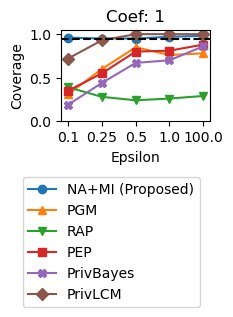

In [29]:
ci_types = [
    "max-ent-all-queries non-negative", 
    "PGM non-split", "rap-all-queries non-split", 
    "PEP non-split", 
    "PrivBayes non-split",
    "privLCM non-negative",
    # "privLCM non-split",
]
markers = {
    "max-ent-all-queries non-negative": "o", 
    "PGM non-split": "^", 
    "rap-all-queries non-split": "v", 
    "PEP non-split": "s", 
    "privLCM non-negative": "D",
    "PrivBayes non-split": "X"
}
fig, axes = plt.subplots(1, 1, figsize=(2.5, 1.85))
sdf = coverages.loc[conf_level, :, 0, :]
for ci_type in ci_types:
    cover_by_eps = sdf.loc[:, ci_type].copy()
    cover_by_eps.drop(10.0, inplace=True)
    axes.plot(cover_by_eps.index.astype(str), cover_by_eps, label=algorithm_labels[ci_type], marker=markers[ci_type], markersize=6)

axes.set_ylim(0, 1.05)
axes.axhline(conf_level, linestyle="dashed", color="black")
axes.set_title("Coef: {}".format(true_params[0]))
axes.set_xlabel("Epsilon")
axes.set_ylabel("Coverage")
leg_h, leg_l = axes.get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=1)

plt.tight_layout()
plt.savefig(figdir + "toy_data_summary_coverages_coef_1.pdf", bbox_inches="tight")
plt.show()

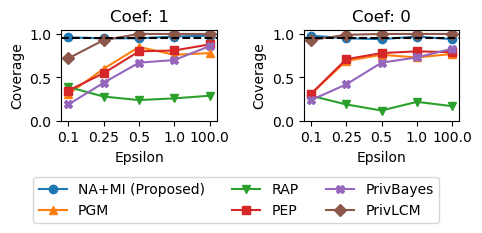

In [30]:
ci_types = [
    "max-ent-all-queries non-negative", 
    "PGM non-split", "rap-all-queries non-split", 
    "PEP non-split", 
    "PrivBayes non-split",
    "privLCM non-negative",
    # "privLCM non-split",
]
markers = {
    "max-ent-all-queries non-negative": "o", 
    "PGM non-split": "^", 
    "rap-all-queries non-split": "v", 
    "PEP non-split": "s", 
    "privLCM non-negative": "D",
    "PrivBayes non-split": "X"
}
fig, axes = plt.subplots(1, 2, figsize=(5.0, 1.85))
for i in range(d):
    sdf = coverages.loc[conf_level, :, i, :]
    for ci_type in ci_types:
        cover_by_eps = sdf.loc[:, ci_type].copy()
        cover_by_eps.drop(10.0, inplace=True)
        axes[i].plot(cover_by_eps.index.astype(str), cover_by_eps, label=algorithm_labels[ci_type], marker=markers[ci_type], markersize=6)
    
    axes[i].set_ylim(0, 1.05)
    axes[i].axhline(conf_level, linestyle="dashed", color="black")
    axes[i].set_title("Coef: {}".format(true_params[i]))
    axes[i].set_xlabel("Epsilon")
    axes[i].set_ylabel("Coverage")
leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=3)

plt.tight_layout()
plt.savefig(figdir + "toy_data_summary_coverages.pdf", bbox_inches="tight")
plt.show()

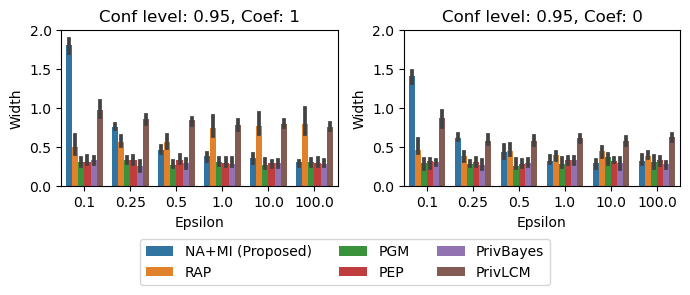

In [31]:
cdf = df.loc[df["algo-type"].apply(lambda at: at in ci_types)].copy()
cdf = cdf.loc[cdf.conf_level == conf_level]
cdf["algo-type"] = cdf["algo-type"].apply(lambda at: algorithm_labels[at])
cdf["length"] += np.random.randn(cdf.shape[0]) * 0.2

fig, axes = plt.subplots(1, d, figsize=(7, 2.5))
for i in range(d):
    ax = axes[i]
    sdf = cdf.loc[cdf["dimension"] == i].loc[cdf["epsilon"].apply(lambda x: x in eps_to_plot)]
    sns.barplot(x="epsilon", y="length", hue="algo-type", data=sdf, estimator=np.median, ax=ax)
    ax.set_title("Conf level: {}, Coef: {}".format(conf_level, true_params[i]))
    ax.set_ylim(0, 2)
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Width")
    ax.get_legend().remove()
leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=3)

plt.tight_layout()
plt.savefig(figdir + "lengths_summary.pdf", bbox_inches="tight")
plt.show()

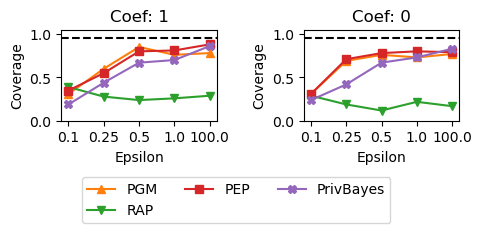

In [23]:
ci_types = [
    # "max-ent-all-queries non-negative", 
    "PGM non-split", "rap-all-queries non-split", 
    "PEP non-split", 
    "PrivBayes non-split",
    # "privLCM non-negative",
    # "privLCM non-split",
]
fig, axes = plt.subplots(1, 2, figsize=(5.0, 1.85))
for i in range(d):
    sdf = coverages.loc[conf_level, :, i, :]
    next(axes[i]._get_lines.prop_cycler) # Skip first color
    for ci_type in ci_types:
        cover_by_eps = sdf.loc[:, ci_type].copy()
        cover_by_eps.drop(10.0, inplace=True)
        axes[i].plot(cover_by_eps.index.astype(str), cover_by_eps, label=algorithm_labels[ci_type], marker=markers[ci_type], markersize=6)
    
    axes[i].set_ylim(0, 1.05)
    axes[i].axhline(conf_level, linestyle="dashed", color="black")
    axes[i].set_title("Coef: {}".format(true_params[i]))
    axes[i].set_xlabel("Epsilon")
    axes[i].set_ylabel("Coverage")
leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=3)

plt.tight_layout()
plt.savefig(figdir + "toy_data_summary_coverages_existing_algos.pdf", bbox_inches="tight")
plt.show()

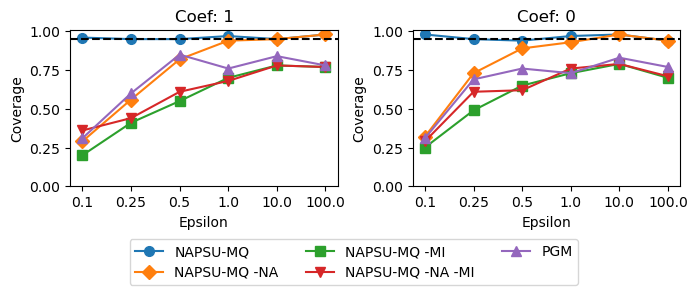

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))

conf_level = 0.95
ci_types = [
    "max-ent-all-queries non-negative", "max-ent-no-noise-aware non-negative", 
    "max-ent-all-queries non-split", "max-ent-no-noise-aware non-split", 
    "PGM non-split"
]
algorithm_labels = {
    "max-ent-all-queries non-negative": "NAPSU-MQ", 
    "max-ent-no-noise-aware non-negative": "NAPSU-MQ -NA", 
    "max-ent-no-noise-aware non-split": "NAPSU-MQ -NA -MI", 
    "max-ent-all-queries non-split": "NAPSU-MQ -MI", 
    "PGM non-split": "PGM"
}
markers = {
    "max-ent-all-queries non-negative": "o", 
    "PGM non-split": "^", 
    "max-ent-no-noise-aware non-split": "v", 
    "max-ent-all-queries non-split": "s", 
    "max-ent-no-noise-aware non-negative": "D", 
}
for i in range(d):
    sdf = coverages.loc[conf_level, :, i, :]
    for ci_type in ci_types:
        cover_by_eps = sdf.loc[:, ci_type]
        axes[i].plot(
            cover_by_eps.index.astype(str), cover_by_eps, 
            label=algorithm_labels[ci_type], marker=markers[ci_type], 
            markersize=7
        )
    
    axes[i].legend()
    axes[i].set_ylim(0, 1.01)
    axes[i].axhline(conf_level, linestyle="dashed", color="black")
    axes[i].set_title("Coef: {}".format(true_params[i]))
    axes[i].set_xlabel("Epsilon")
    axes[i].set_ylabel("Coverage")
    axes[i].get_legend().remove()
leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=3)
   
plt.tight_layout()
plt.savefig(figdir + "toy_data_ablation.pdf", bbox_inches="tight")
plt.show()

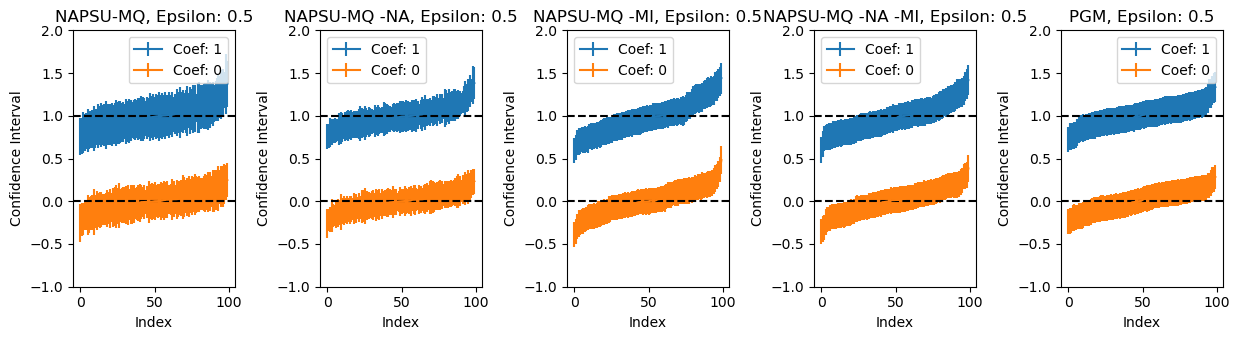

In [26]:
epsilon = 0.5
fig, axes = plt.subplots(1, len(ci_types), figsize=(2.5 * len(ci_types), 3.5))
for i in range(d):
    sdf = df.loc[df["conf_level"] == conf_level].loc[df["dimension"] == i].loc[df["epsilon"] == epsilon]

    for ci_type_index, ci_type in enumerate(ci_types):
        ax = axes[ci_type_index]
        sdf_type = sdf.loc[sdf["algo-type"] == ci_type]
        inds = sdf_type["center"].sort_values().index
        ax.errorbar(
            range(sdf_type.shape[0]), 
            y=sdf_type.loc[inds]["center"],
            yerr=sdf_type.loc[inds]["radius"],
            label="Coef: {}".format(true_params[i])
        )
        ax.axhline(true_params[i], linestyle="dashed", color="black")
        ax.set_title("{}, Epsilon: {}".format(algorithm_labels[ci_type], epsilon))
        ax.set_ylim((-1, 2))
        ax.set_xlabel("Index")
        ax.set_ylabel("Confidence Interval")
        ax.legend()
    
plt.tight_layout()
plt.savefig(figdir + "toy_data_ablation_conf_ints.pdf")
plt.show()